In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from astropy.cosmology import FlatLambdaCDM

class lumfuncs(object):
    def __init__(self, H0, Om0, survey_area, z, lum, z_bins, n_lum_bins):
        """ 
        Class for calculating luminosity functions
        
        Parameters
        ----------
        H0 : float
            The Hubble constant
        
        Om0 : float
            The matter density parameter
        
        survey_area : float
            The area of the survey in square degrees
        
        z : array
            The redshifts of the galaxies in the survey
        
        lum : array
            The luminosities of the galaxies in the survey
        
        z_bins : list
            Start and end point pairs of the bins for the luminosity function
            Example: [(0, 0.1), (0.1, 0.2), (0.2, 0.3)]
        
        n_lum_bins : int
            The number of luminosity bins to use
        """
        self._survey_area = survey_area
        self._cosmo = FlatLambdaCDM(H0, Om0)
        mag_ab = 25 - 2.5 * np.log10(lum)
        self._df = pd.DataFrame({'z': z, 'lum': mag_ab})
        self._df = self._df.sort_values('lum')   
        self._df.to_csv('test.csv')     
        self._z = self._df['z'].values
        self._lum = self._df['lum'].values
        self._z_bins = np.array(z_bins)
        _, self._lum_bin_edges = np.histogram(self._lum, bins=n_lum_bins)
        self._lum_bin_tuples = [(self._lum_bin_edges[i], self._lum_bin_edges[i+1]) for i in range(len(self._lum_bin_edges)-1)]
    
    def _calc_volumes(self, source_zs, z_end):
        """ 
        Given a set of sources binned by redshift and binned by luminosity
        Step 1: Calculate the comoving distance of the sources and the distance to the end of the redshift bin
        Step 2: Calculate the volume of the shell between the sources and the end of the redshift bin
        Step 3: Correct the volume for the survey area
        """
        dmins = self._cosmo.comoving_distance(source_zs).value
        dmaxs = self._cosmo.comoving_distance(z_end).value
        
        vmins = 4/3 * np.pi * dmins ** 3
        vmaxs = 4/3 * np.pi * dmaxs ** 3

        volumes = vmaxs - vmins
        
        corrected_area = self._survey_area / 41253
        volumes *= corrected_area
        return volumes        
    
    def bin_volumes(self):
        """ Calculate the volume of sources after binning in redshift and then binning in luminosity """
        all_volumes = []
        z = self._df['z'].values
        
        # Bin in redshift
        for z_min, z_max in self._z_bins:
            z_mask = (z_min <= z ) & (z < z_max)
            df_bin_z = self._df[z_mask] # all sources within redshift bin
            
            redshift_volumes = []
            lum = df_bin_z['lum'].values
            
            # Bin in luminosity
            for lum_min, lum_max in self._lum_bin_tuples:
                lum_mask = (lum_min <= lum) & (lum < lum_max)
                df_bin_lum = df_bin_z[lum_mask] # all sources within luminosity bin at redshift bin
                
                # Calculate volume
                zs = df_bin_lum['z'].values
                luminosity_volumes = self._calc_volumes(zs, z_max)
                redshift_volumes.append(luminosity_volumes)
                
            all_volumes.append(redshift_volumes)
        return all_volumes     
    
    def phi(self):
        """ Returns the luminosity function phi values for each redshift bin """
        delta_log_l = np.diff(self._lum_bin_tuples)[0]
        volumes = self.bin_volumes()
        
        phi_all = []
        for z_volume in volumes: # redshift bins
            phi_zbin = []
            for lum_volume in z_volume: # luminosity bins in redshift bin
                phi_lumbin = 1 / delta_log_l * np.sum(1 / lum_volume)
                phi_zbin.append(phi_lumbin)
            phi_all.append(np.ravel(phi_zbin))
        return phi_all   
    
    def plot_phi(self):
        """ Plots the luminosity function """
        phi = self.phi()
        lums = self._lum_bin_edges[:-1]
        for phi_z, (z_start, z_end) in zip(phi, self._z_bins):
            plt.scatter(lums, phi_z, label=f'{z_start} $\leq$ z < {z_end}')
            plt.yscale('log')
            plt.xlabel(r'$M_{AB}$')
            plt.ylabel(r'$log(\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')
            plt.legend()
            plt.show()
            
    def plot_lum_hist(self):
        """ Plots the luminosity histogram """
        plt.hist(self._lum, bins=20)
        plt.xlabel(r'$M_{AB}$')
        plt.ylabel('Count')
        plt.show()

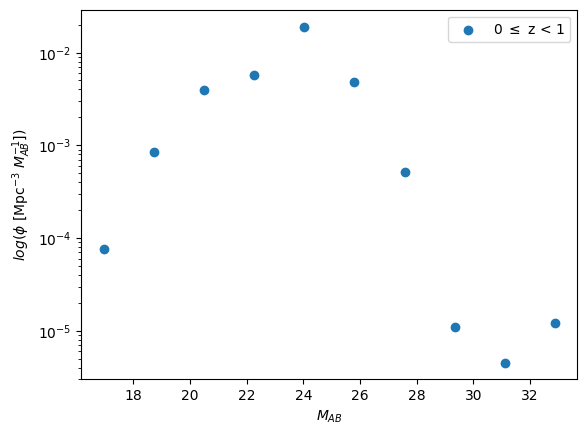

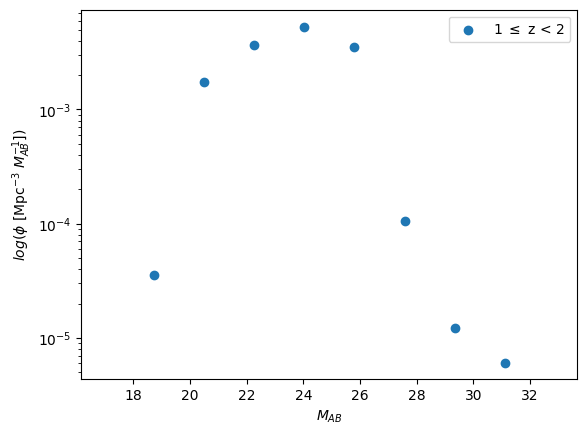

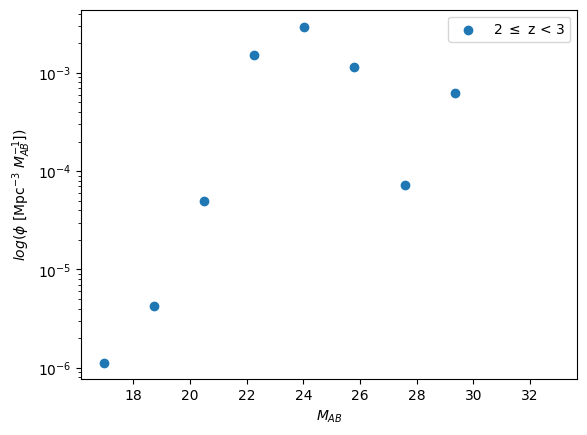

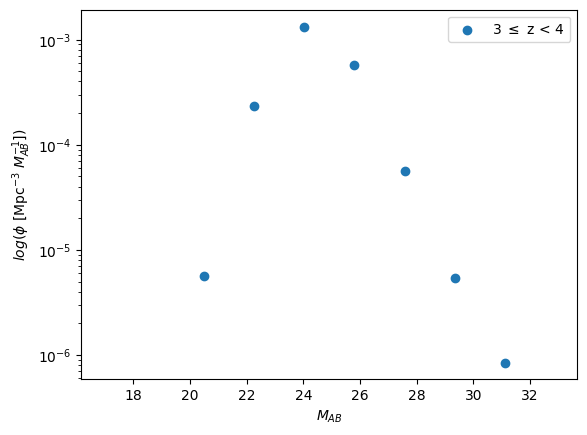

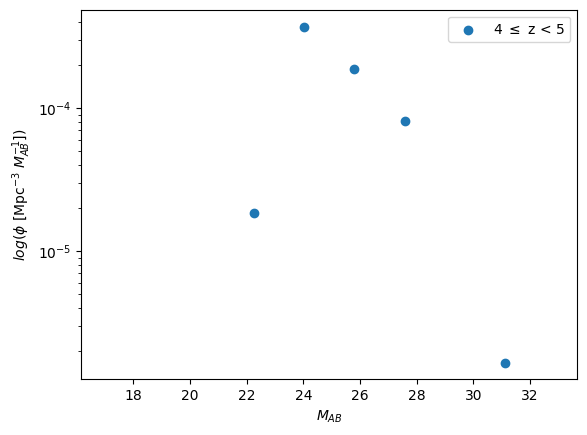

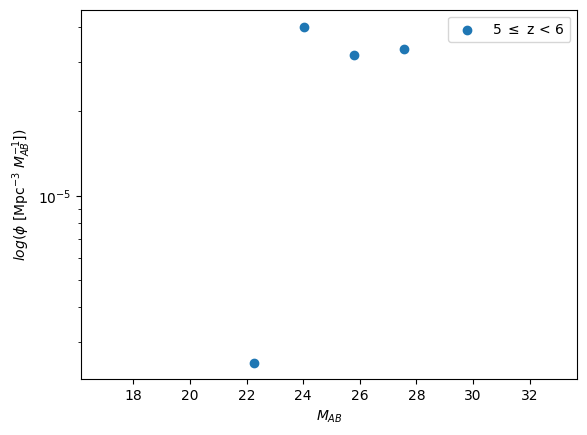

In [10]:
import pandas as pd

# Read in CDFS main data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data) # 30,911 galaxies
df = df[df['Use'] == 1] # 13,299 galaxies
df = df[df['FKs'] > 0] # 12,676 galaxies

H0 = 70 # km/s/Mpc
Om0 = 0.3 # matter density parameter
survey_area = 0.11 # square degrees
z = df['zpk'] # redshifts
lum = df['FKs'] # luminosities
z_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
n_lum_bins = 10 # number of luminosity bins

source = lumfuncs(H0, Om0, survey_area, z, lum, z_bins, n_lum_bins)
source.plot_phi()